# Librerías e importaciones

In [2]:
!pip install meteostat
!pip install geocoder
!pip install geopy

  Created wheel for meteostat: filename=meteostat-1.5.10-py3-none-any.whl size=29174 sha256=f2112282934d54af5a5d5f019e5b10555f3f3d9c447d96ec1df936ff566b68d5
  Stored in directory: /root/.cache/pip/wheels/c7/4e/10/6cd64c2c65bddd4c84d161e702ad98f3fc41b4c45ec7da6065
Successfully built meteostat
     |████████████████████████████████| 98 kB 3.8 MB/s 


In [31]:
import pandas as pd
import json
import ast
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from meteostat import Point, Hourly, Daily, Monthly
from fbprophet import Prophet
import datetime
import numpy as np

# Exploración de datos

In [4]:
# Acceso a gdrive para datos
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Saturdays_AI_DL"

Mounted at /content/drive


In [5]:
dfconsumption = pd.read_csv(path + "/holaluz/consumptions_small.csv", sep=';')
dfcups = pd.read_csv(path + "/holaluz/cups_info_small.csv", sep=';')
dfcalendario = pd.read_csv(path +"/festivities/calendario.csv", sep=';')

In [6]:
# Consumo (consumptions_small.csv)
dfconsumption.head()

,day,consumption,consumption_type,id
0,2019-12-01,"{1.139,2.04}","{TELEM,TELEM}",39653
1,2019-12-02,"{1.163,2.328}","{TELEM,TELEM}",39653
2,2019-12-03,"{0.873,2.578}","{TELEM,TELEM}",39653
3,2019-12-04,"{0.997,3.089}","{TELEM,TELEM}",39653
4,2019-12-05,"{1.818,3.694}","{TELEM,TELEM}",39653


In [7]:
# Consumidor (cups_info_small.csv)
dfcups.head()

,id,atr,power,zipcode,locality,ekon_start
0,39653,2.0TD,"{4600,4600}",28052,NaN,2021-09-01


In [8]:
# Festivos
dfcalendario.head()

,Día,Día_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
0,01/01/2013,martes,festivo,Festivo nacional,Año Nuevo
1,02/01/2013,miércoles,laborable,NaN,NaN
2,03/01/2013,jueves,laborable,NaN,NaN
3,04/01/2013,viernes,laborable,NaN,NaN
4,05/01/2013,sábado,sábado,NaN,NaN


# Limpieza y preparación de datos

In [9]:

# Normalizamos los datos de consumo
dfconsumption.consumption = dfconsumption.consumption.apply(lambda x: ast.literal_eval(x.replace("{", "(").replace("}", ")")))
dfconsumption['total_consumption'] = dfconsumption.consumption.apply(lambda x: sum(x))

In [10]:
# Descartar lecturas de NO telemetría
dfconsumption = dfconsumption[dfconsumption.consumption_type.str.contains("TELEM")]

In [11]:
dfconsumption.head()

,day,consumption,consumption_type,id,total_consumption
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512


In [12]:
# Hacemos join con los datos de las dos tablas, una contiene los datos de consumos y la otra los datos del consumidor
dfmerged = pd.merge(left=dfconsumption, right=dfcups, left_on='id', right_on='id')
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01


In [13]:
# Necesitamos encontrar todos los diferentes zipcode del dataset y con sus fechas mínimas y máximas para la obtención de datos meteorológicos
df_zipcodes = dfmerged.groupby('zipcode').agg({'day': ['min', 'max']})
display(df_zipcodes.head())
df_zipcodes.info()

day            
                min         max
zipcode                        
28052    2019-12-01  2021-05-31

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 28052 to 28052
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   (day, min)  1 non-null      object
 1   (day, max)  1 non-null      object
dtypes: object(2)
memory usage: 24.0+ bytes


In [14]:
# Recorremos todos los zipcode y poblamos un nuevo dataset con zipcode, fechas y datos meteorológicos diarios
geolocator = Nominatim(user_agent='test')
df = pd.DataFrame(columns=['time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'zipcode'])
for index, x in df_zipcodes.iterrows():
  location = geolocator.geocode(str(x.name) + ", Spain")
  point = Point(location.latitude, location.longitude)
  data = Daily(point, pd.to_datetime(x.day.min()), pd.to_datetime(x.day.max()))
  data = data.fetch()
  # Obtenemos los datos de luz diaria con los datos mensuales
  dataMonth = Monthly(point, pd.to_datetime(x.day.min()), pd.to_datetime(x.day.max()))
  dataMonth = dataMonth.fetch()
  dataMonth = dataMonth.reset_index()
  # data.plot(y=['tavg', 'tmin', 'tmax'])
  data['zipcode'] = x.name
  data = data.reset_index()
  data['month'] = pd.to_datetime(data.time).dt.month
  data['year'] = pd.to_datetime(data.time).dt.year
  dataMonth['month'] = pd.to_datetime(dataMonth.time).dt.month
  dataMonth['year'] = pd.to_datetime(dataMonth.time).dt.year
  data = pd.merge(
    data, 
    dataMonth[['tsun', 'month', 'year']], 
    on=['month', 'year'],
    how='left')
  data['tsun'] = data['tsun_y']/30
  data = data.drop(['month', 'year', 'tsun_x', 'tsun_y'], axis = 1)
  df = df.append(data)
  print(pd.to_datetime(x.day.min()))
  print(pd.to_datetime(x.day.max()))
  print(location.address)
df_zipcodes.head()

# Los datos ya estarían listos para hacer join por el zipcode con los datos del consumer



2019-12-01 00:00:00
2021-05-31 00:00:00
Puente de Vallecas, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28052, España


day            
                min         max
zipcode                        
28052    2019-12-01  2021-05-31

In [15]:
# Tenemos que transformar el valor object a datetime
dfmerged['day'] =  pd.to_datetime(dfmerged['day'])
# Unimos las dos tablas a través del zipcode y la fecha
dfmerged = pd.merge(left=dfmerged, right=df, left_on=['zipcode', 'day'], right_on=['zipcode', 'time'], how='left')
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0


In [16]:
dfmerged.head(10000)

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,2021-05-27,"(1.571, 2.006)","{TELEM,TELEM}",39653,3.577,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-27,21.3,15.4,26.2,2.0,NaN,66.0,8.8,NaN,1015.2,604.0
544,2021-05-28,"(1.72, 3.096)","{TELEM,TELEM}",39653,4.816,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-28,20.7,15.3,26.2,0.0,NaN,100.4,6.9,NaN,1016.3,604.0
545,2021-05-29,"(0.713, 1.976)","{TELEM,TELEM}",39653,2.689,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-29,23.0,16.1,29.9,0.0,NaN,47.4,8.3,NaN,1018.0,604.0
546,2021-05-30,"(3.275, 3.238)","{TELEM,TELEM}",39653,6.513,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-30,24.3,17.7,30.6,0.0,NaN,22.5,10.7,NaN,1015.4,604.0


In [17]:
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0


# Prophet: Preparación de datos y Test Set



In [18]:
# Prophet necesita un dataset para los festivos y no laborales para valorar el impacto
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
# Sustituimos el formato de fecha actual y lo adaptamos a los otros datasets
# Prophet tambien nos pide una ventana de tiempo anterior y posterior a la fecha vacacional
dfcalendario["ds"] = pd.to_datetime(dfcalendario['Día'], format="%d/%m/%Y").dt.strftime("%Y-%m-%d")
dffestivities = pd.DataFrame({"ds": dfcalendario["ds"], 'lower_window': -3, 'upper_window' : 1, 'holiday': dfcalendario['laborable / festivo / domingo festivo']})
dffestivities.head()


,ds,lower_window,upper_window,holiday
0,2013-01-01,-3,1,festivo
1,2013-01-02,-3,1,laborable
2,2013-01-03,-3,1,laborable
3,2013-01-04,-3,1,laborable
4,2013-01-05,-3,1,sábado


In [19]:
# Convertimos a booleanos los festivos al nuevo dataset a partir del calendario de festivos
dffestivities['isholiday'] = (dffestivities['holiday'] == 'sábado') | (dffestivities['holiday'] == 'domingo') | (dffestivities['holiday'] == 'festivo')
# Cruzamos datos
dffestivities['day'] = dffestivities['ds'].astype('datetime64')
dfmerged = pd.merge(left=dfmerged, right=dffestivities[['isholiday','day']], left_on='day', right_on='day', how='left')
dfmerged.head(10)

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isholiday
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0,False
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0,False
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0,False
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0,False
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0,False
5,2019-12-06,"(6.084, 3.62)","{TELEM,TELEM}",39653,9.704,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-06,9.1,6.7,12.5,0.0,NaN,0.1,6.0,NaN,1023.5,276.0,True
6,2019-12-07,"(0.881, 2.32)","{TELEM,TELEM}",39653,3.201,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-07,7.5,3.7,12.0,0.0,NaN,308.5,4.8,NaN,1025.8,276.0,False
7,2019-12-08,"(1.476, 2.016)","{TELEM,TELEM}",39653,3.492,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-08,5.6,4.1,7.0,2.7,NaN,356.9,3.0,NaN,1027.7,276.0,False
8,2019-12-09,"(1.603, 3.227)","{TELEM,TELEM}",39653,4.830,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-09,7.0,4.7,11.6,0.0,NaN,69.1,5.1,NaN,1030.1,276.0,True
9,2019-12-10,"(1.08, 4.116)","{TELEM,TELEM}",39653,5.196,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-10,5.2,3.9,8.0,0.0,NaN,338.5,5.0,NaN,1031.0,276.0,False


In [20]:
# Para festivities filtramos solo los que son festivo
dffestivities = dffestivities[dffestivities['isholiday'] == True]
dffestivities.head(10)

,ds,lower_window,upper_window,holiday,isholiday,day
0,2013-01-01,-3,1,festivo,True,2013-01-01
4,2013-01-05,-3,1,sábado,True,2013-01-05
5,2013-01-06,-3,1,domingo,True,2013-01-06
6,2013-01-07,-3,1,festivo,True,2013-01-07
11,2013-01-12,-3,1,sábado,True,2013-01-12
12,2013-01-13,-3,1,domingo,True,2013-01-13
18,2013-01-19,-3,1,sábado,True,2013-01-19
19,2013-01-20,-3,1,domingo,True,2013-01-20
25,2013-01-26,-3,1,sábado,True,2013-01-26
26,2013-01-27,-3,1,domingo,True,2013-01-27


In [21]:
# Prophet necesita la columna "y", variable a predecir y la columna "ds" como timestamp para el timeseries
# Por aquí
# Antes de entrenar el modelo escogeremos solo las columnas que son necesarias
dataset = dfmerged.loc[:, ('day', 'total_consumption', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'tsun', 'isholiday')]
dataset['y'] = dfmerged['total_consumption']
dataset.rename(columns={"day": "ds"}, inplace=True)
dataset.ds.max()



Timestamp('2021-05-31 00:00:00')

In [22]:
# Existen algunos Nan que reemplazaremos por 0
dataset = dataset.fillna(0)

In [97]:
# Para el test vamos a hacer una predicción de 90 días, creamos los training y test a partir de este número
test_days = 90
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)


,ds,total_consumption,tavg,tmin,tmax,prcp,wdir,wspd,pres,tsun,isholiday,y
547,2021-05-31,5.202,23.5,18.2,30.9,6.3,199.8,12.6,1013.1,604.0,False,5.202


# Prophet: Modelo

In [98]:
# Facebook Prophet model. Holidays es un dataframe aparte que hemos construido
m = Prophet(growth="linear", 
            yearly_seasonality=True,
            weekly_seasonality=True, 
            daily_seasonality=False, 
            holidays=dffestivities, 
            seasonality_mode = "multiplicative", 
            seasonality_prior_scale = 10,
            holidays_prior_scale= 0.05)
# Agregamos regresores al modelo
# Controlamos también isholiday como regressor del dataframe de dataset y todos los datos climatológicos
m.add_regressor('isholiday')
# Temperatura media
m.add_regressor('tavg')
# Temperatura mínima
m.add_regressor('tmin')
# Temperatura máxima
m.add_regressor('tmax')
# Precipitaciones
m.add_regressor('prcp')
# Dirección del viento
m.add_regressor('wdir')
# Velocidad del viento
m.add_regressor('wspd')
# Minutos de sol
m.add_regressor('tsun')
# Entrenamos el modelo
m.fit(training_set)

# Forecasting

In [99]:
# Creamos el Future Dataframe, será el dataframe con los valores relativos al futuro. 
# La frecuencia será "D", un día
future = m.make_future_dataframe (periods = len(test_set), freq = "D")
# Vemos que los datos corresponden al último día del dataframe de test
print('dataset', dataset.tail(1))
print('training_set', training_set.tail(1))
print('test_set', test_set.tail(1))
print('future', future.tail(1))

dataset             ds  total_consumption  tavg  tmin  ...    pres   tsun  isholiday      y
547 2021-05-31              5.202  23.5  18.2  ...  1013.1  604.0      False  5.202

[1 rows x 12 columns]
training_set             ds  total_consumption  tavg  tmin  ...    pres   tsun  isholiday      y
457 2021-03-02              4.599  10.7   7.9  ...  1026.4  456.0      False  4.599

[1 rows x 12 columns]
test_set             ds  total_consumption  tavg  tmin  ...    pres   tsun  isholiday      y
547 2021-05-31              5.202  23.5  18.2  ...  1013.1  604.0      False  5.202

[1 rows x 12 columns]
future             ds
547 2021-05-31


In [100]:
# Juntamos los regressors del dataset al future
future = pd.concat([future, dataset.iloc[:,2:]], axis = 1)
future.tail()

,ds,tavg,tmin,tmax,prcp,wdir,wspd,pres,tsun,isholiday,y
543,2021-05-27,21.3,15.4,26.2,2.0,66.0,8.8,1015.2,604.0,False,3.577
544,2021-05-28,20.7,15.3,26.2,0.0,100.4,6.9,1016.3,604.0,False,4.816
545,2021-05-29,23.0,16.1,29.9,0.0,47.4,8.3,1018.0,604.0,False,2.689
546,2021-05-30,24.3,17.7,30.6,0.0,22.5,10.7,1015.4,604.0,False,6.513
547,2021-05-31,23.5,18.2,30.9,6.3,199.8,12.6,1013.1,604.0,False,5.202


In [101]:
# Forecast. Hacemos nuestra predicción, yhat será nuestra predicción
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,domingo,domingo_lower,domingo_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,festivo,festivo_lower,festivo_upper,holidays,holidays_lower,holidays_upper,isholiday,isholiday_lower,isholiday_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,prcp,prcp_lower,prcp_upper,sábado,sábado_lower,sábado_upper,tavg,tavg_lower,tavg_upper,tmax,tmax_lower,tmax_upper,tmin,tmin_lower,tmin_upper,tsun,tsun_lower,tsun_upper,wdir,wdir_lower,wdir_upper,weekly,weekly_lower,weekly_upper,wspd,wspd_lower,wspd_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-12-01,5.836874,1.502227,7.507157,5.836874,5.836874,0.0,0.0,0.0,-0.127346,-0.127346,-0.127346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.214994,-0.214994,-0.214994,-0.054858,-0.054858,-0.054858,0.0,0.0,0.0,-0.009337,-0.009337,-0.009337,-0.017656,-0.017656,-0.017656,-0.014900,-0.014900,-0.014900,-0.040902,-0.040902,-0.040902,0.015363,0.015363,0.015363,-0.031569,-0.031569,-0.031569,-0.005055,-0.005055,-0.005055,-0.056079,-0.056079,-0.056079,0.0,0.0,0.0,4.581983
1,2019-12-02,5.839920,2.067313,8.151273,5.839920,5.839920,0.0,0.0,0.0,-0.051531,-0.051531,-0.051531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.127645,-0.127645,-0.127645,0.003240,0.003240,0.003240,0.0,0.0,0.0,-0.009337,-0.009337,-0.009337,-0.014028,-0.014028,-0.014028,-0.018658,-0.018658,-0.018658,-0.040902,-0.040902,-0.040902,0.021444,0.021444,0.021444,-0.030865,-0.030865,-0.030865,0.006710,0.006710,0.006710,-0.045249,-0.045249,-0.045249,0.0,0.0,0.0,5.094485
2,2019-12-03,5.842965,1.957449,7.802506,5.842965,5.842965,0.0,0.0,0.0,-0.077871,-0.077871,-0.077871,0.013271,0.013271,0.013271,0.013271,0.013271,0.013271,0.0,0.0,0.0,-0.156673,-0.156673,-0.156673,-0.001096,-0.001096,-0.001096,0.0,0.0,0.0,-0.012328,-0.012328,-0.012328,-0.017138,-0.017138,-0.017138,-0.029095,-0.029095,-0.029095,-0.040902,-0.040902,-0.040902,0.023312,0.023312,0.023312,-0.056486,-0.056486,-0.056486,-0.000624,-0.000624,-0.000624,-0.035587,-0.035587,-0.035587,0.0,0.0,0.0,4.927533
3,2019-12-04,5.846011,1.976237,8.164212,5.846011,5.846011,0.0,0.0,0.0,-0.058480,-0.058480,-0.058480,-0.002275,-0.002275,-0.002275,-0.002275,-0.002275,-0.002275,0.0,0.0,0.0,-0.119677,-0.119677,-0.119677,-0.001096,-0.001096,-0.001096,0.0,0.0,0.0,-0.008768,-0.008768,-0.008768,-0.012646,-0.012646,-0.012646,-0.018240,-0.018240,-0.018240,-0.040902,-0.040902,-0.040902,0.023948,0.023948,0.023948,-0.031910,-0.031910,-0.031910,-0.000777,-0.000777,-0.000777,-0.027012,-0.027012,-0.027012,0.0,0.0,0.0,5.146376
4,2019-12-05,5.849056,2.391565,8.568368,5.849056,5.849056,0.0,0.0,0.0,-0.039337,-0.039337,-0.039337,-0.003690,-0.003690,-0.003690,-0.003690,-0.003690,-0.003690,0.0,0.0,0.0,-0.070050,-0.070050,-0.070050,0.003240,0.003240,0.003240,0.0,0.0,0.0,-0.006632,-0.006632,-0.006632,-0.011955,-0.011955,-0.011955,-0.007803,-0.007803,-0.007803,-0.040902,-0.040902,-0.040902,0.023352,0.023352,0.023352,-0.007619,-0.007619,-0.007619,0.001362,0.001362,0.001362,-0.019404,-0.019404,-0.019404,0.0,0.0,0.0,5.439328


In [102]:
# Estudiamos los valores de las predicciones
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet.head()

458    5.672755
459    5.873179
460    6.372172
461    7.309687
462    6.206643
Name: prophet, dtype: float64

# Visualización de resultados

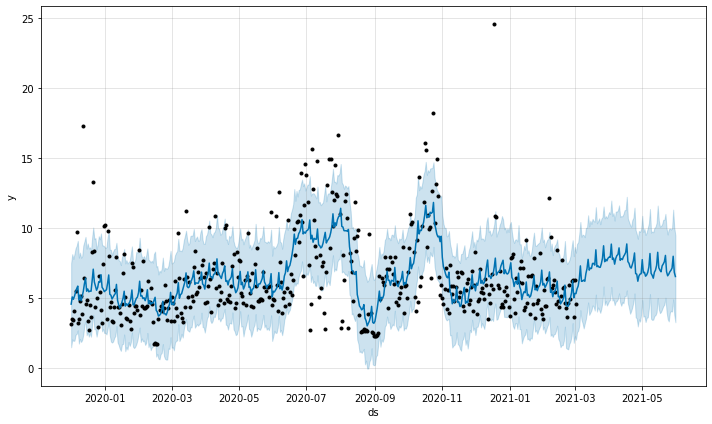

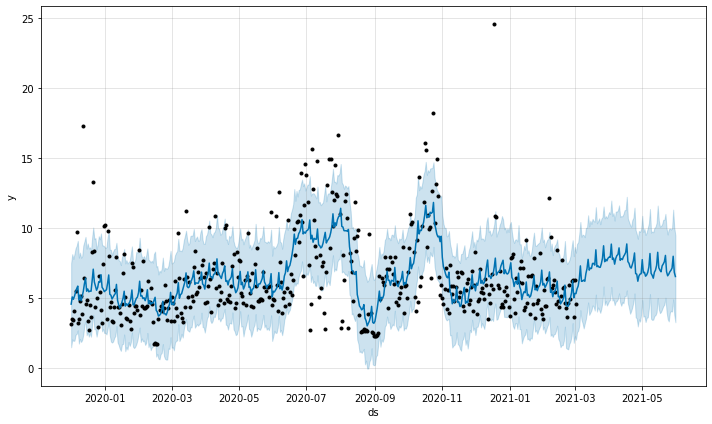

In [103]:
# Utilizaremos algunos métodos "built-in" de Prophet
m.plot(forecast)

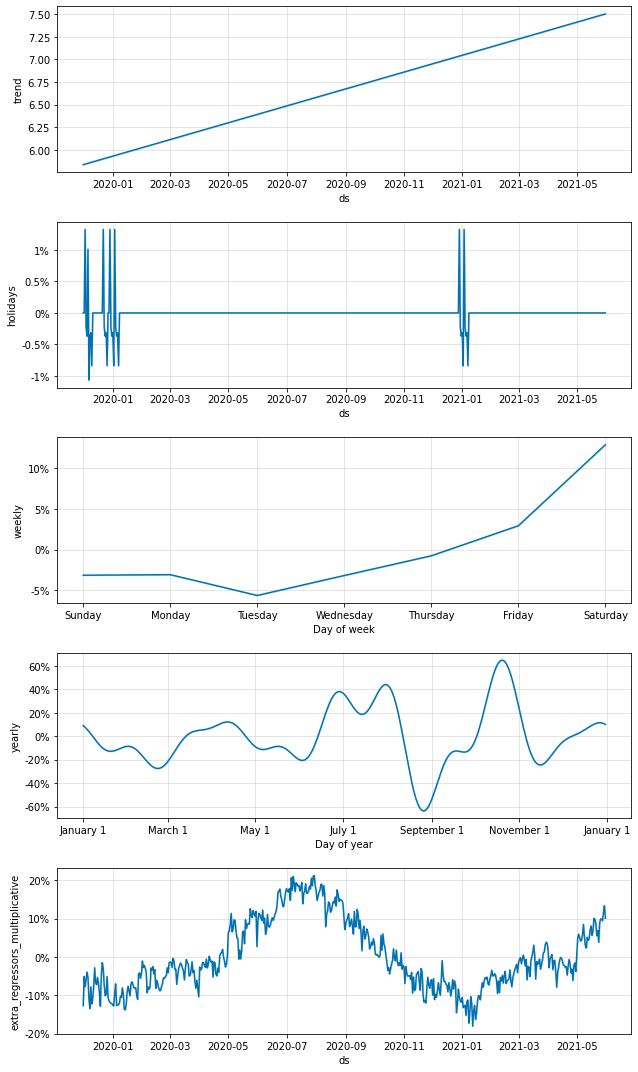

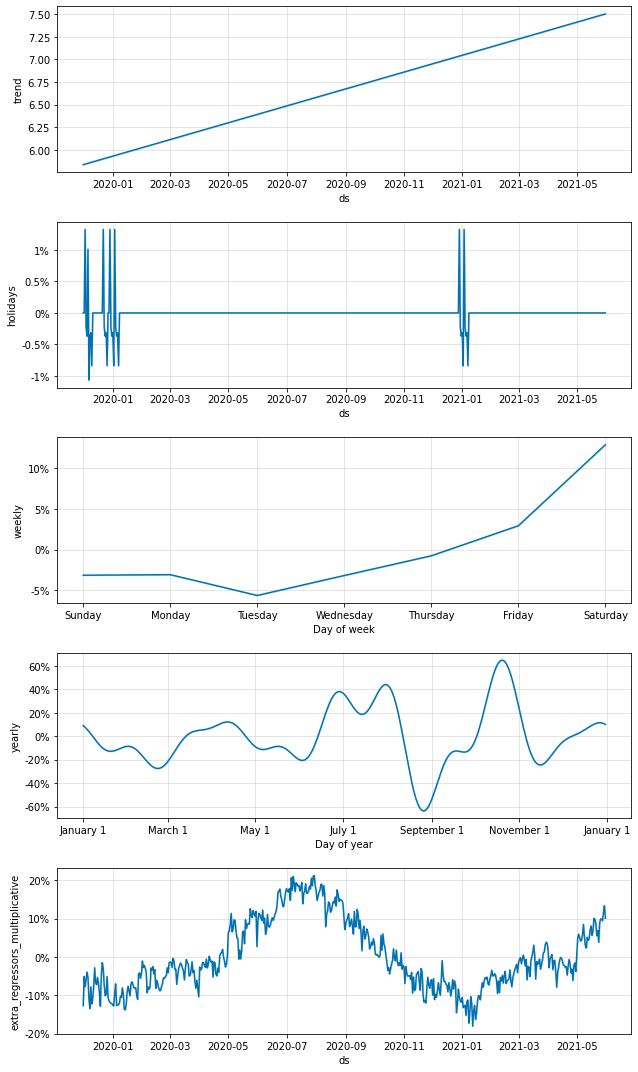

In [104]:
# plot components
m.plot_components(forecast)

# Evaluación del modelo

Para la evaluación de nuestro modelo vamos a usar las típicas técnicas de evaluación de error "Mean Squared Error" y "Mean Absolute Error"

In [105]:
# MAE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

3.0
3.0


In [106]:
# MAPE Mean Absolute Perdcentage Error
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

89.2904588693466

# Cross Validation

In [116]:
# Validación cruzada, usamos el método "built in" de prophet
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, 
                         horizon = str(test_days)+' days', # Cuántos días en el futuro vamos a predecir, los definidos en el test
                         initial = '366 days', # Cuándo vamos a iniciar la validación, intentaremos no empezar antes de un año de diferencia
                         parallel = "processes")
df_cv.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f584bd1d910>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
85,2021-02-26,4.827792,1.889314,7.824655,6.247,2020-12-02
86,2021-02-27,5.877776,2.795698,8.895076,6.283,2020-12-02
87,2021-02-28,4.843472,1.850060,7.869021,3.664,2020-12-02
88,2021-03-01,5.085027,2.012094,8.071176,6.317,2020-12-02
89,2021-03-02,5.076244,2.013868,8.244717,4.599,2020-12-02


In [118]:
# MAE, RMSE, MAPE de Cross Validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

2.0
3.0
35.89033966698564


Son unos buenos resultados con los valores que obtenemos a partir de los primeros hiperparámetros que establecimos, vamos a intentar mejorar estas cifras probando nuevos valores

# Hiperparámetros

En prophet tenemos 3 tipos de hiperparámetros que podemos mejorar


*   seasonality_prior_scale: Peso de la estacionalidad o periodo del año
*   holiday_prior_scale: Cuanto mayores son los valores más pesarán los parámetros dedicados a las vacaciones
*   changepoint_prior_scale: Flexibilidad de la tendencia del modelo, cuánto peso le vamos a otorgar a la tendencia





Para poder explorar los hiperparámetros de una manera más rápida crearemos un ParameterGrid de varias dimensiones que nos permitirá explorar múltipes combinaciones de hiperparámetros

In [119]:
# Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5,10,20],
              'changepoint_prior_scale': [0.01,0.05,0.1],
              'holidays_prior_scale': [5,10,20]
              }
grid = ParameterGrid(param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [124]:
# Ajuste de hiperparámetros
rmse = []
for params in grid:
  # Recuperamos el modelo que establecimos anteriormente
  m = Prophet(growth="linear", 
              yearly_seasonality=True,
              weekly_seasonality=True, 
              daily_seasonality=False, 
              holidays=dffestivities, 
              seasonality_mode = "multiplicative", 
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale=  params['holidays_prior_scale'],
              changepoint_prior_scale=  params['changepoint_prior_scale'],
              )
  # Workingday del dataframe de dataset
  m.add_regressor('isholiday')
  # Temperatura media
  m.add_regressor('tavg')
  # Temperatura mínima
  m.add_regressor('tmin')
  # Temperatura máxima
  m.add_regressor('tmax')
  # Precipitaciones
  m.add_regressor('prcp')
  # Dirección del viento
  m.add_regressor('wdir')
  # Velocidad del viento
  m.add_regressor('wspd')
  # Minutos de sol
  m.add_regressor('tsun')
  # Entrenamos el modelo
  m.fit(training_set)

  # cross-validation
  df_cv = cross_validation(m, 
                          horizon = str(test_days)+' days', 
                         initial = '366 days',
                         parallel = "processes")

  # guardamos los resultados
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

  rmse.append(error)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f584d2d2610>
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f584c6aa1d0>
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f584cb21c10>
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f584bdcee90>
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-12-02 00:00:00 and 2020-12-02 00:00:00
INFO:fbprophet:Applying in parallel with <con

In [125]:
# Mejores parámetros, los escogemos por el mejor RMSE guardado en el array de rmse
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.05}


# Modelo final

In [128]:
# Con los parámetros que hemos seleccionado construimos nuestro modelo final
# Una vez hemos conseguido los mejores parámetros del test anterior, vamos a definir el modelo con los mismos (sustituimos params por best_params)
m = Prophet(growth="linear", 
              yearly_seasonality=True,
              weekly_seasonality=True, 
              daily_seasonality=False, 
              holidays=dffestivities, 
              seasonality_mode = "multiplicative", 
              seasonality_prior_scale = best_params['seasonality_prior_scale'],
              holidays_prior_scale=  best_params['holidays_prior_scale'],
              changepoint_prior_scale=  best_params['changepoint_prior_scale'],
              )
m.add_regressor('isholiday')
# Temperatura media
m.add_regressor('tavg')
# Temperatura mínima
m.add_regressor('tmin')
# Temperatura máxima
m.add_regressor('tmax')
# Precipitaciones
m.add_regressor('prcp')
# Dirección del viento
m.add_regressor('wdir')
# Velocidad del viento
m.add_regressor('wspd')
# Minutos de sol
m.add_regressor('tsun')
# Entrenamos el modelo
m.fit(training_set)

In [129]:
# Future dataframe
future = m.make_future_dataframe(periods = len(test_set),freq="D")
# regressors
future = pd.concat([future, dataset.iloc[:,2:]], axis = 1)
future.tail()

,ds,tavg,tmin,tmax,prcp,wdir,wspd,pres,tsun,isholiday,y
543,2021-05-27,21.3,15.4,26.2,2.0,66.0,8.8,1015.2,604.0,False,3.577
544,2021-05-28,20.7,15.3,26.2,0.0,100.4,6.9,1016.3,604.0,False,4.816
545,2021-05-29,23.0,16.1,29.9,0.0,47.4,8.3,1018.0,604.0,False,2.689
546,2021-05-30,24.3,17.7,30.6,0.0,22.5,10.7,1015.4,604.0,False,6.513
547,2021-05-31,23.5,18.2,30.9,6.3,199.8,12.6,1013.1,604.0,False,5.202


In [131]:
# Forecast
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,domingo,domingo_lower,domingo_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,festivo,festivo_lower,festivo_upper,holidays,holidays_lower,holidays_upper,isholiday,isholiday_lower,isholiday_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,prcp,prcp_lower,prcp_upper,sábado,sábado_lower,sábado_upper,tavg,tavg_lower,tavg_upper,tmax,tmax_lower,tmax_upper,tmin,tmin_lower,tmin_upper,tsun,tsun_lower,tsun_upper,wdir,wdir_lower,wdir_upper,weekly,weekly_lower,weekly_upper,wspd,wspd_lower,wspd_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
543,2021-05-27,7.390175,4.009801,9.882968,7.390175,7.390175,0.0,0.0,0.0,0.117475,0.117475,0.117475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055632,-0.055632,-0.055632,-0.001454,-0.001454,-0.001454,0.0,0.0,0.0,-0.004915,-0.004915,-0.004915,0.007200,0.007200,0.007200,0.032742,0.032742,0.032742,0.069203,0.069203,0.069203,0.019131,0.019131,0.019131,-0.005988,-0.005988,-0.005988,-0.004431,-0.004431,-0.004431,-0.167119,-0.167119,-0.167119,0.0,0.0,0.0,6.979048
544,2021-05-28,7.392970,4.143160,10.286605,7.392970,7.392970,0.0,0.0,0.0,0.113970,0.113970,0.113970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.036742,-0.036742,-0.036742,0.004299,0.004299,0.004299,0.0,0.0,0.0,-0.004513,-0.004513,-0.004513,0.007200,0.007200,0.007200,0.032160,0.032160,0.032160,0.069203,0.069203,0.069203,0.013700,0.013700,0.013700,0.028202,0.028202,0.028202,-0.008078,-0.008078,-0.008078,-0.178915,-0.178915,-0.178915,0.0,0.0,0.0,7.121335
545,2021-05-29,7.395765,4.633444,11.058607,7.395765,7.395766,0.0,0.0,0.0,0.131797,0.131797,0.131797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071694,0.071694,0.071694,0.004299,0.004299,0.004299,0.0,0.0,0.0,-0.006053,-0.006053,-0.006053,0.010859,0.010859,0.010859,0.036812,0.036812,0.036812,0.069203,0.069203,0.069203,0.022068,0.022068,0.022068,0.130074,0.130074,0.130074,-0.005391,-0.005391,-0.005391,-0.190177,-0.190177,-0.190177,0.0,0.0,0.0,7.925999
546,2021-05-30,7.398561,3.792992,9.740763,7.398561,7.398561,0.0,0.0,0.0,0.149461,0.149461,0.149461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082678,-0.082678,-0.082678,0.004299,0.004299,0.004299,0.0,0.0,0.0,-0.006923,-0.006923,-0.006923,0.011551,0.011551,0.011551,0.046115,0.046115,0.046115,0.069203,0.069203,0.069203,0.026000,0.026000,0.026000,-0.031700,-0.031700,-0.031700,-0.000784,-0.000784,-0.000784,-0.200438,-0.200438,-0.200438,0.0,0.0,0.0,6.786864
547,2021-05-31,7.401356,3.577154,9.271622,7.401356,7.401356,0.0,0.0,0.0,0.110729,0.110729,0.110729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.130673,-0.130673,-0.130673,-0.013824,-0.013824,-0.013824,0.0,0.0,0.0,-0.006387,-0.006387,-0.006387,0.011848,0.011848,0.011848,0.049022,0.049022,0.049022,0.069203,0.069203,0.069203,-0.001995,-0.001995,-0.001995,-0.032172,-0.032172,-0.032172,0.002863,0.002863,0.002863,-0.209230,-0.209230,-0.209230,0.0,0.0,0.0,6.434196


In [132]:
# Con el modelo final construido y entrenado vamos a crear las predicciones finales
predictions_prophet_final = forecast.yhat[-test_days:].rename("prophet_final")
predictions_prophet_final.index = test_set["ds"]
predictions_prophet_final.head()

ds
2021-03-03    5.776166
2021-03-04    5.981413
2021-03-05    6.445766
2021-03-06    7.386100
2021-03-07    6.286785
Name: prophet_final, dtype: float64

In [136]:
# Exportamos el forecast de los siguientes 180 días a csv
print(path)
predictions_prophet_final.to_csv(path + '/predictions_hw.csv', index = True)

/content/drive/My Drive/Saturdays_AI_DL
